In [3]:
import pandas as pd
import numpy as np
from colorama import Fore
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from sklearn.feature_extraction import DictVectorizer as DV
# Appearence
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN 

In [4]:
"""Сводные показатели"""
aggregates = pd.read_csv('../input/besthack-2021/aggregates.csv') # Данные
# aggregates_info = pd.read_excel('../input/besthack-2021/aggregates.xlsx') # Описание признаков

"""Сделки"""
transactions = pd.read_csv('../input/besthack-2021/transactions.csv') # Данные
# transactions_info = pd.read_excel('../input/besthack-2021/transactions.xlsx') # Данные

In [5]:
aggregates.head()

,client_id,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,...,curdel_30plus_bki,curdel_60plus_bank,curdel_60plus_bki,curdel_tech_bank,curdel_tech_bki,bank_1_29_5y_debtor,bank_30_59_5y_debtor,bank_60_89_5y_debtor,bank_90_119_5y_debtor,bank_120plus_5y_debtor
0,4268,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8951,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3485,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8008,2019-11-01 00:00:00,2.0,6.0,12.0,24.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1615,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
len(aggregates)

177963

In [7]:
transactions.head()

,client_id,last_day_month,mcc_group,att_sum,att_cnt,att_sum_min,att_sum_max,att_sum_avg
0,1322,2019-12-31,TRANSPORTATION,90.00,3,23.00,44.0,30.000000
1,7737,2019-05-31,RETAIL STORES,989.00,5,99.00,423.0,197.800000
2,9549,2020-03-31,NON FOOD RETAIL,11878.55,24,52.79,2303.0,494.939583
3,4562,2019-12-31,FINANCIAL SERVICES,15000.00,1,15000.00,15000.0,15000.000000
4,7112,2020-02-29,BUSINESS SERVICES,887.60,3,107.10,413.7,295.866666


In [8]:
len(transactions)

751747

<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">1. Объединение таблиц 🤝</p>  
По заданию нам даны 2 таблицы различной длины:  
**aggregates: (~178000 x 220)**  
**transactions: (~752000 x 8)**  
C общими столбцами `client_id`. Для начала следует узнать, действительно ли значения id пересекаются в этих двух таблицах:

In [9]:
print('кол-во уникальных значений client_id в aggregates:', len(set(aggregates.client_id)),
      '\nкол-во уникальных значений client_id в transactions:', len(set(transactions.client_id)), '\n',
     )

def same_value(l1, l2):
    sv_list = []
    for x in l1:
        if x in l2:
            sv_list.append(x)
    return set(sv_list)

print('кол-во пересекающихся значений client_id в aggregates и transactions:', len(same_value(aggregates.client_id, transactions.client_id)))


кол-во уникальных значений client_id в aggregates: 9895 
кол-во уникальных значений client_id в transactions: 9925 

кол-во пересекающихся значений client_id в aggregates и transactions: 9895


Как видно, таблица `transactions` содержит все элементы таблицы `aggregates` + свои собственные уникальные значения.  
Идея состоит в том, чтобы объеденить таблицы без использования стандартных SQL joins, поскольку сами таблицы не сбалансированы (Одна из таблиц в 4 раза больше другой).  
Вместо этого, мы будем **генерировать фичи для aggregates, используя информацию из transactions**

## О, времена! О, нравы! О, мой кошелёк!    
Поскольку на одну отчетную дату `report_date` из `aggregates` в среднем приходится несколько отчетных дат `last_day_month` из `transactions`, представляет ценность информация о том,  
какие траты совершает пользователь в промежутках между `aggregates.report_date`.  
В разное время года люди тратят на одни и те же вещи разные суммы денег. Это может быть связано с какими то жизненными событиями а-ля дни рождения, праздники, перемены в жизни...  
Поэтому даже если человек не планировал брать потребительский кредит, его решение может измениться в ходе подобных событий.  
По моему мнению, наилучший способ показать тенденцию увеличения потребностей - добавление новых признаков на основе таблицы `transactions`. Будем считать ссумарные траты по каждой из категорий в заданный промежуток времени.  
Для начала следует привести значения столбца с датами из обеих таблиц к одному виду, а затем отсортировать

In [ ]:
"""aggregates"""

aggregates.insert(1, 'report_date_dt', pd.to_datetime(aggregates['report_date'], format='%Y-%m-%d'), True)
aggregates.insert(2, 'weekday', aggregates['report_date_dt'].dt.weekday, True)
aggregates.insert(3, 'month', aggregates['report_date_dt'].dt.month, True)
aggregates.insert(4, 'year', aggregates['report_date_dt'].dt.year, True)

aggregates.drop('report_date', axis = 1, inplace = True)

aggregates.sort_values(by='report_date_dt', inplace = True) # Сортируем даты в порядке возрастания

"""transactions"""

transactions.insert(1, 'report_date_dt', pd.to_datetime(transactions['last_day_month'], format='%Y-%m-%d'), True)
transactions.insert(2, 'weekday', transactions['report_date_dt'].dt.weekday, True)
transactions.insert(3, 'month', transactions['report_date_dt'].dt.month, True)
transactions.insert(4, 'year', transactions['report_date_dt'].dt.year, True)

transactions.drop('last_day_month', axis = 1, inplace = True)

transactions.sort_values(by='report_date_dt', inplace = True) # Сортируем даты в порядке возрастания

<a id='1'></a>
## <p style="background-color:LightCoral; font-family:newtimeroman; font-size:150%; text-align:center">transactions. подготовка к добавлению новых фичей </p>    
Для начала посмотрим, какие категории покупок представлены в таблице

In [10]:
print(set(transactions.mcc_group), '\nКолличество категорий: ', len(set(transactions.mcc_group)))

{'PERSONAL SERVICES', 'CONSTRUCTION SERVICES', 'PRINTING SERVICES', 'PUBLIC SERVICE', 'WHOLESALE', 'FINANCIAL SERVICES', 'ENTERTAINMENT', 'RETAIL STORES', 'unknown', 'REPAIR SERVICES', 'SALES BY MAIL AND PHONE', 'AUTO', 'CHARITY', 'AIRLINES', 'UNCLASSIFIED PAYMENTS', 'MEDICAL SERVICES', 'VEHICLE RENTAL', 'EDUCATION', 'SERVICE PROVIDER', 'TRANSPORTATION', 'BUSINESS SERVICES', 'GOVERNMENT SERVICES', 'LEGAL SERVICES', 'BAR', 'HOTEL', 'GAMBLING', 'NON FOOD RETAIL', 'CLOTHING STORES'} 
Колличество категорий:  28


Всего в группе МСС представлено 28 различных значений, включая 2 неопределенных: `UNCLASSIFIED PAYMENTS`, `unknown`, которые впоследствии можно объединить.  
Также можно обратить внимание на то, что потребительский кредит берется на суммы ~100 000р, так что наиболее "дорогие" признаки будут занижать вероятность взять кредит

Удаление в `transactions` тех `client_id`, которые не представлены в `aggregates`

In [ ]:
"""Список повторяющихся id"""
id_list = aggregates['client_id'].unique()

"""DataFrame transactions только с теми значениями client_id, которые представлены в таблице aggregates"""

transactions_upd = transactions.loc[transactions['client_id'].isin(id_list)]

# СПОРНЫЙ МОМЕНТ (кол-во уникальных значений client_id в aggregates: 9895 
# кол-во уникальных значений client_id в transactions_upd: 9825 )

id_list = transactions_upd['client_id'].unique()

"""DataFrame aggregates только с теми значениями client_id, которые представлены в таблице transactions_upd"""

aggregates_upd = aggregates.loc[aggregates['client_id'].isin(id_list)]
aggregates_data = aggregates_upd # Создание копии для последующих манипуляций с таблицами

print('кол-во уникальных значений client_id в aggregates:', len(aggregates_upd['client_id'].unique()),
      '\nкол-во уникальных значений client_id в transactions_upd:', len(transactions_upd['client_id'].unique()),
     )
print(Fore.GREEN + 'Теперь client_id полностью совпадают')

<a id='1'></a>
## <p style="background-color:LightCoral; font-family:newtimeroman; font-size:150%; text-align:center">Генерирование фичей на основе transactions. Обоснование алгоритма</p>  

Обе таблицы: `aggregates`, `transactions` содержат столбец `report_date (last_day_month)`, обозначающий отчетную дату. Правда в случае `aggregates` под отчетной датой понимается сухой банковский отчет по каждому клиенту о его кредитоспособности, а в случае `transactions` - под отчетной датой понимаются транзакционные отчеты клиента по конкретным категориям трат. **При этом следует заметить**:  
- `aggregates.report_date` начинается с `2019-01-01`  
- `transactions.last_day_month` начинается с `2018-06-30`  
  
По сути все отчеты можно представить в следующем виде:  
![](https://sun9-47.userapi.com/impf/ix0n3eFRyTTZTvIpyX2n-7Dn2Bpa-QJ2u9MqrQ/lbYPceOiWfY.jpg?size=2160x662&quality=96&sign=2ac9e377bce0af5592ecb965d06a1f81&type=album)  
Каждый клиент в промежутке между отчетными датами тратит свои деньги на различные категории товаров, а именно:  

> **{'PUBLIC SERVICE', 'GOVERNMENT SERVICES', 'GAMBLING', 'CLOTHING STORES', 'UNCLASSIFIED PAYMENTS', 'BAR', 'EDUCATION', 'NON FOOD RETAIL', 'MEDICAL SERVICES', 'AIRLINES', 'VEHICLE RENTAL', 'HOTEL', 'unknown', 'PRINTING SERVICES', 'CONSTRUCTION SERVICES', 'SERVICE PROVIDER', 'REPAIR SERVICES', 'WHOLESALE', 'PERSONAL SERVICES', 'CHARITY', 'AUTO', 'TRANSPORTATION', 'LEGAL SERVICES', 'FINANCIAL SERVICES', 'RETAIL STORES', 'BUSINESS SERVICES', 'ENTERTAINMENT', 'SALES BY MAIL AND PHONE'}  
Колличество категорий:  28**  

Кроме информации о категория трат, в таблице `transactions` также представлены столбцы:
- Суммарные транзакции по категориям в отчетный период
- Количество транзакций
- Минимальная транзакция
- Максимальная транзакция
- Средняя транзакция  
**Чтобы объединить информацию из обеих таблиц, предлагается поступить следующим образом:**  
Для каждого клиента смотрим траты, совершенные им между отчетными периодами из `aggregates` (все эти траты помещаются в заштрихованную синюю область между отчетами `aggregates` на рисунке).  
  
  
При этом нас интересует не "суммарная" информация о тратах, а траты по конкретным категориям товаров. Как пример рассмотрим клиента "Мишу":  
![](https://sun9-61.userapi.com/impf/j6G-u8h7cncXXvEfCM3gOKuW1JRMLoVI92XA5w/BlvCyppcCvU.jpg?size=1620x1055&quality=96&sign=0a20e4e7e18b5b818d0365afb3418767&type=album)  
Как видно в разные отрезки времени клиенты могут тратить разные суммы на разные категории товаров.  
Клиент может потратить небольшую сумму на каждую из категорий, либо же потратить большую сумму денег на какую то конкретную категорию. Вариантов здесь масса.  
**Данная информация в совокупе с информацией о зарплатных начислениях может стать ключевой при ответе на вопрос "насколько клиент склонен взять кредит?"**  
  
Реализуем алгоритм, при котором в нашу исходную таблицу `aggregates` добавятся признаки, соответсвующие тратам (и смежным с ними характеристиками из таблицы `transactions`) по каждой из категории товаров для каждого клиента в отдельные промежутки времени

In [ ]:
"""Список отчетных дат в таблице aggregates"""

date_list = aggregates_upd['report_date_dt'].unique()

## Следующие ячейки выполняются довольно медленно, поэтому к письму приложен готовый csv файл 

In [ ]:
"""суммарные траты"""

mcc_list = list(set(transactions_upd.mcc_group))
#mcc_list = ['TRANSPORTATION', 'REPAIR SERVICES']

for mcc in mcc_list: # проходимся в цикле по категориям товаров
    
    for i_date in range(len(date_list)): # Должны учитывать только те даты, которые попадают в нужный нам диапазон 
        
        if i_date == 0: # для первой отчетной даты из aggregates должны учитывать все траты до этой даты
            att_sum_frame = transactions_upd[(transactions_upd['report_date_dt'] <= date_list[i_date]) 
                                             & (transactions_upd['mcc_group'] == mcc)].groupby('client_id', as_index=False)['att_sum'].sum() / 7 # в первом случае учитываются траты за 7 отчетных периодов. Усредняем показатели
        else: # для второй и далее отчетной даты из aggregates должны учитывать все траты в промежутке между соседними отчетными датами
            att_sum_frame = transactions_upd[(transactions_upd['report_date_dt'] <= date_list[i_date]) & (transactions_upd['report_date_dt'] > date_list[i_date - 1]) 
                                             & (transactions_upd['mcc_group'] == mcc)].groupby('client_id', as_index=False)['att_sum'].sum()
        
        att_sum_frame['report_date_dt'] = date_list[i_date]
        
        aggregates_upd = aggregates_upd.merge(att_sum_frame, on = ['client_id', 'report_date_dt'], how = 'left') # добавляем суммарные траты по категории к таблице aggregates, учитывая 'client_id' и 'report_date_dt'
        aggregates_upd.iloc[:, -1].fillna(0)
        
    att_sum = aggregates_upd.iloc[:, aggregates_upd.columns.str.contains('att_sum')].sum(1)
    cols_to_drop = list(aggregates_upd.columns[aggregates_upd.columns.str.contains('att_sum')])
    aggregates_upd.drop(cols_to_drop, axis=1, inplace = True)
    aggregates_upd['{}_attsum'.format(mcc)] = att_sum

In [ ]:
"""суммарное количество покупок"""

for mcc in mcc_list:
    
    for i_date in range(1, len(date_list)):
        
        if i_date == 0:
            att_sum_frame = transactions_upd[(transactions_upd['report_date_dt'] <= date_list[i_date]) 
                                             & (transactions_upd['mcc_group'] == mcc)].groupby('client_id', as_index=False)['att_cnt'].sum() / 7
        else:
            att_sum_frame = transactions_upd[(transactions_upd['report_date_dt'] <= date_list[i_date]) & (transactions_upd['report_date_dt'] > date_list[i_date - 1]) 
                                             & (transactions_upd['mcc_group'] == mcc)].groupby('client_id', as_index=False)['att_cnt'].sum()
        
        att_sum_frame['report_date_dt'] = date_list[i_date]
        
        aggregates_upd = aggregates_upd.merge(att_sum_frame, on = ['client_id', 'report_date_dt'], how = 'left')
        aggregates_upd.iloc[:, -1].fillna(0)
        
    att_sum = aggregates_upd.iloc[:, aggregates_upd.columns.str.contains('att_cnt')].sum(1)
    cols_to_drop = list(aggregates_upd.columns[aggregates_upd.columns.str.contains('att_cnt')])
    aggregates_upd.drop(cols_to_drop, axis=1, inplace = True)
    aggregates_upd['{}_attcnt'.format(mcc)] = att_sum
    

In [ ]:
"""минимальная покупка"""

for mcc in mcc_list:
    
    for i_date in range(1, len(date_list)):
        
        if i_date == 0:
            att_sum_frame = transactions_upd[(transactions_upd['report_date_dt'] <= date_list[i_date]) 
                                             & (transactions_upd['mcc_group'] == mcc)].groupby('client_id', as_index=False)['att_sum_min'].min()
        else:
            att_sum_frame = transactions_upd[(transactions_upd['report_date_dt'] <= date_list[i_date]) & (transactions_upd['report_date_dt'] > date_list[i_date - 1]) 
                                             & (transactions_upd['mcc_group'] == mcc)].groupby('client_id', as_index=False)['att_sum_min'].min()
        
        att_sum_frame['report_date_dt'] = date_list[i_date]
        
        aggregates_upd = aggregates_upd.merge(att_sum_frame, on = ['client_id', 'report_date_dt'], how = 'left')
        aggregates_upd.iloc[:, -1].fillna(0)
        
    att_sum = aggregates_upd.iloc[:, aggregates_upd.columns.str.contains('att_sum_min')].min(1)
    cols_to_drop = list(aggregates_upd.columns[aggregates_upd.columns.str.contains('att_sum_min')])
    aggregates_upd.drop(cols_to_drop, axis=1, inplace = True)
    aggregates_upd['{}_attsummin'.format(mcc)] = att_sum
    aggregates_upd.iloc[:, -1].fillna(0, inplace = True)

In [ ]:
"""максимальная покупка"""

for mcc in mcc_list:
    
    for i_date in range(1, len(date_list)):
        
        if i_date == 0:
            att_sum_frame = transactions_upd[(transactions_upd['report_date_dt'] <= date_list[i_date]) 
                                             & (transactions_upd['mcc_group'] == mcc)].groupby('client_id', as_index=False)['att_sum_max'].max()
        else:
            att_sum_frame = transactions_upd[(transactions_upd['report_date_dt'] <= date_list[i_date]) & (transactions_upd['report_date_dt'] > date_list[i_date - 1]) 
                                             & (transactions_upd['mcc_group'] == mcc)].groupby('client_id', as_index=False)['att_sum_max'].max()
            
        att_sum_frame['report_date_dt'] = date_list[i_date]
        
        aggregates_upd = aggregates_upd.merge(att_sum_frame, on = ['client_id', 'report_date_dt'], how = 'left')
        aggregates_upd.iloc[:, -1].fillna(0)
        
    att_sum = aggregates_upd.iloc[:, aggregates_upd.columns.str.contains('att_sum_max')].max(1)
    cols_to_drop = list(aggregates_upd.columns[aggregates_upd.columns.str.contains('att_sum_max')])
    aggregates_upd.drop(cols_to_drop, axis=1, inplace = True)
    aggregates_upd['{}_attsummax'.format(mcc)] = att_sum
    aggregates_upd.iloc[:, -1].fillna(0, inplace = True)

Сортировка по столбцам

In [ ]:
for mcc in mcc_list:
    aggregates_data[list(aggregates_upd.columns[aggregates_upd.columns.str.contains('{}'.format(mcc))])] = aggregates_upd[list(aggregates_upd.columns[aggregates_upd.columns.str.contains('{}'.format(mcc))])].values

<a id='1'></a>
## <p style="background-color:LightCoral; font-family:newtimeroman; font-size:150%; text-align:center">UNCLASSIFIED PAYMENTS и unknown объединяем в одну общую категорию UNKNOWN</p>  


In [ ]:
aggregates_data['UNKNOWN_attsum'] = aggregates_data['UNCLASSIFIED PAYMENTS_attsum'] + aggregates_data['unknown_attsum']
aggregates_data.drop(['UNCLASSIFIED PAYMENTS_attsum', 'unknown_attsum'], axis=1, inplace = True)

aggregates_data['UNKNOWN_attcnt'] = aggregates_data['UNCLASSIFIED PAYMENTS_attcnt'] + aggregates_data['unknown_attcnt']
aggregates_data.drop(['UNCLASSIFIED PAYMENTS_attcnt', 'unknown_attcnt'], axis=1, inplace = True)

aggregates_data['UNKNOWN_attsummin'] = aggregates_data[['UNCLASSIFIED PAYMENTS_attsummin', 'unknown_attsummin']].min(1)
aggregates_data.drop(['UNCLASSIFIED PAYMENTS_attsummin', 'unknown_attsummin'], axis=1, inplace = True)

aggregates_data['UNKNOWN_attsummax'] = aggregates_data[['UNCLASSIFIED PAYMENTS_attsummax', 'unknown_attsummax']].max(1)
aggregates_data.drop(['UNCLASSIFIED PAYMENTS_attsummax', 'unknown_attsummax'], axis=1, inplace = True)

<a id='1'></a>
## <p style="background-color:LightCoral; font-family:newtimeroman; font-size:150%; text-align:center">Сохраняем таблицу aggregates_data</p> 

In [ ]:
aggregates_data.iloc[:, aggregates_upd.columns.str.contains('_attcnt')].astype('int32')
aggregates_data.to_csv('train_data.csv', index=False)
aggregates_data

<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">2. Визуализация & Чистка Данных 📊</p>  

In [11]:
"""Импорт таблицы"""
train_data = pd.read_csv('../input/train-data-for-hackathon/train_data.csv')

train_data.iloc[:, train_data.columns.str.contains('_attcnt')].astype('int32'); # Забыл заменить тип данных до сохранения таблицы. Впоследствии исправить

### Для начала посмотрим на общую структуру данных

In [12]:
print(train_data.info(verbose = True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177469 entries, 0 to 177468
Data columns (total 331 columns):
 #    Column                             Dtype  
---   ------                             -----  
 0    client_id                          int64  
 1    report_date_dt                     object 
 2    weekday                            int64  
 3    month                              int64  
 4    year                               int64  
 5    cnt_zp_1m                          float64
 6    cnt_zp_3m                          float64
 7    cnt_zp_6m                          float64
 8    cnt_zp_12m                         float64
 9    downlimit_count                    float64
 10   uplimit_count                      float64
 11   limit_exchange_count               float64
 12   cur_credit_limit                   float64
 13   cur_cr_lim_month                   float64
 14   prev_credit_limit                  float64
 15   max_outstanding_amount_1m          float64
 16   

Таким образом, превалирующий тип данных - `Float`. Для удобства предобработки данных, разделим датасет на несколько таблиц в зависимости от типа данных

In [13]:
train_data.select_dtypes(include='object') # для категорий report_date_dt и cre_date следует заменить тип данных на timestamp

,report_date_dt,app_rel_status,app_education_nm,app_industry_nm,app_employment_type_nm,app_position_type_nm,app_client_category,cre_date
0,2019-01-01,Женат/Замужем,Незаконченное высшее,ТЭК/ химия и нефтехимия,технический персонал,не руководящий сотрудник,Прочие физические лица,2018-02-27 00:00:00
1,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,,,ТЭК/ химия и нефтехимия,0,,"Сотрудники Группы ГПБ, Группы Газпром и сотруд...",NaN
...,...,...,...,...,...,...,...,...
177464,2020-10-01,,,наука/ образование/ культура,0,,Прочие физические лица,2020-04-01 00:00:00
177465,2020-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177466,2020-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177467,2020-10-01,Состоит в зарегистрированном браке,Высшее,Добывающая пром-ть,Основная сфера деят-ти,не руководящий сотрудник,"Сотрудники Группы ГПБ, Группы Газпром и сотруд...",2020-08-31 00:00:00


In [14]:
train_data['report_date_dt'] = pd.to_datetime(train_data['report_date_dt'], format='%Y-%m-%d')
train_data['cre_date'] = pd.to_datetime(train_data['cre_date'], format='%Y-%m-%d')

In [15]:
# отбор числовых колонок
cont_data = train_data.select_dtypes(include = ['float64', 'int64'])

# отбор нечисловых колонок
cat_data = train_data.select_dtypes(include = ['object'])

<a id='1'></a>
## <p style="background-color:LightCoral; font-family:newtimeroman; font-size:150%; text-align:center">Отсутствующие данные</p> 

Text(0.5, 0, 'кол-во пропущенных значений в строчках')

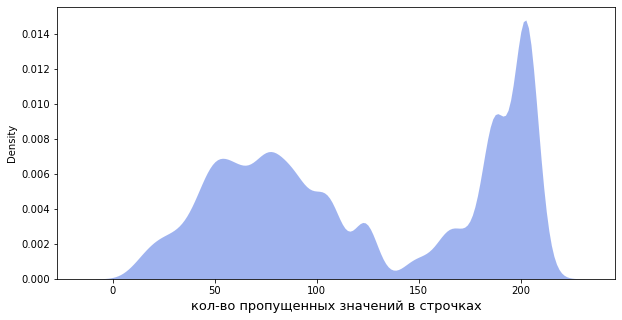

In [16]:
plt.figure(figsize=(10, 5))
"""Для начала посмотрим по всему датасету, сколько строк не имеют пропущенных значений"""
train_data_copy = train_data

for col in train_data_copy.columns:
    missing = train_data_copy[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        #print('created missing indicator for: {}'.format(col))
        train_data_copy['{}_ismissing'.format(col)] = missing

ismissing_cols = [col for col in train_data_copy.columns if 'ismissing' in col]
train_data_copy['num_missing'] = train_data_copy[ismissing_cols].sum(axis=1)

sns.kdeplot(train_data_copy['num_missing'], fill=True, color = 'royalblue',
            alpha=.5, linewidth=0)
plt.xlabel('кол-во пропущенных значений в строчках', size = 13)

Как видно из распределения, почти все строчки имеют пропущенные значения. Зачастую пропущенные значения присутствуют в почти каждом признаке.  
Отдельно посчитаем процентное содержание NULL значений в колонке `cre_date`

In [17]:
pct_missing = np.mean(train_data['cre_date'].isnull())
print('процентное содержание пропусков в cre_date - {}%'.format(round(pct_missing*100)))

процентное содержание пропусков в cre_date - 66%


<a id='1'></a>
## <p style="background-color:LightCoral; font-family:newtimeroman; font-size:150%; text-align:center">2.1 Категориальные признаки 💬</p> 

<AxesSubplot:>

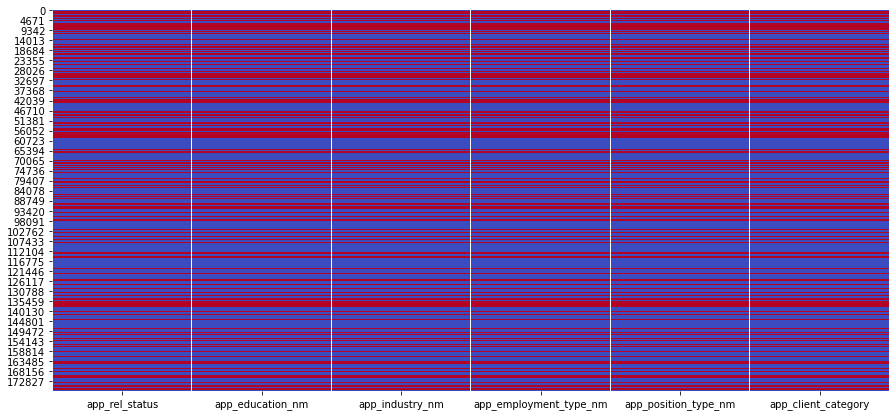

In [18]:
plt.figure(figsize=(15, 7))
sns.heatmap(cat_data.isnull(), cmap='coolwarm', cbar = False)

Прослеживается закономерность: для каждого клиента либо присутствуют все категориальные признаки, либо же не присутствуют никакие  
  
Прежде чем заполнять NULL значения, следует посмотреть на распределение вписанных в таблицу значений (not NULL)

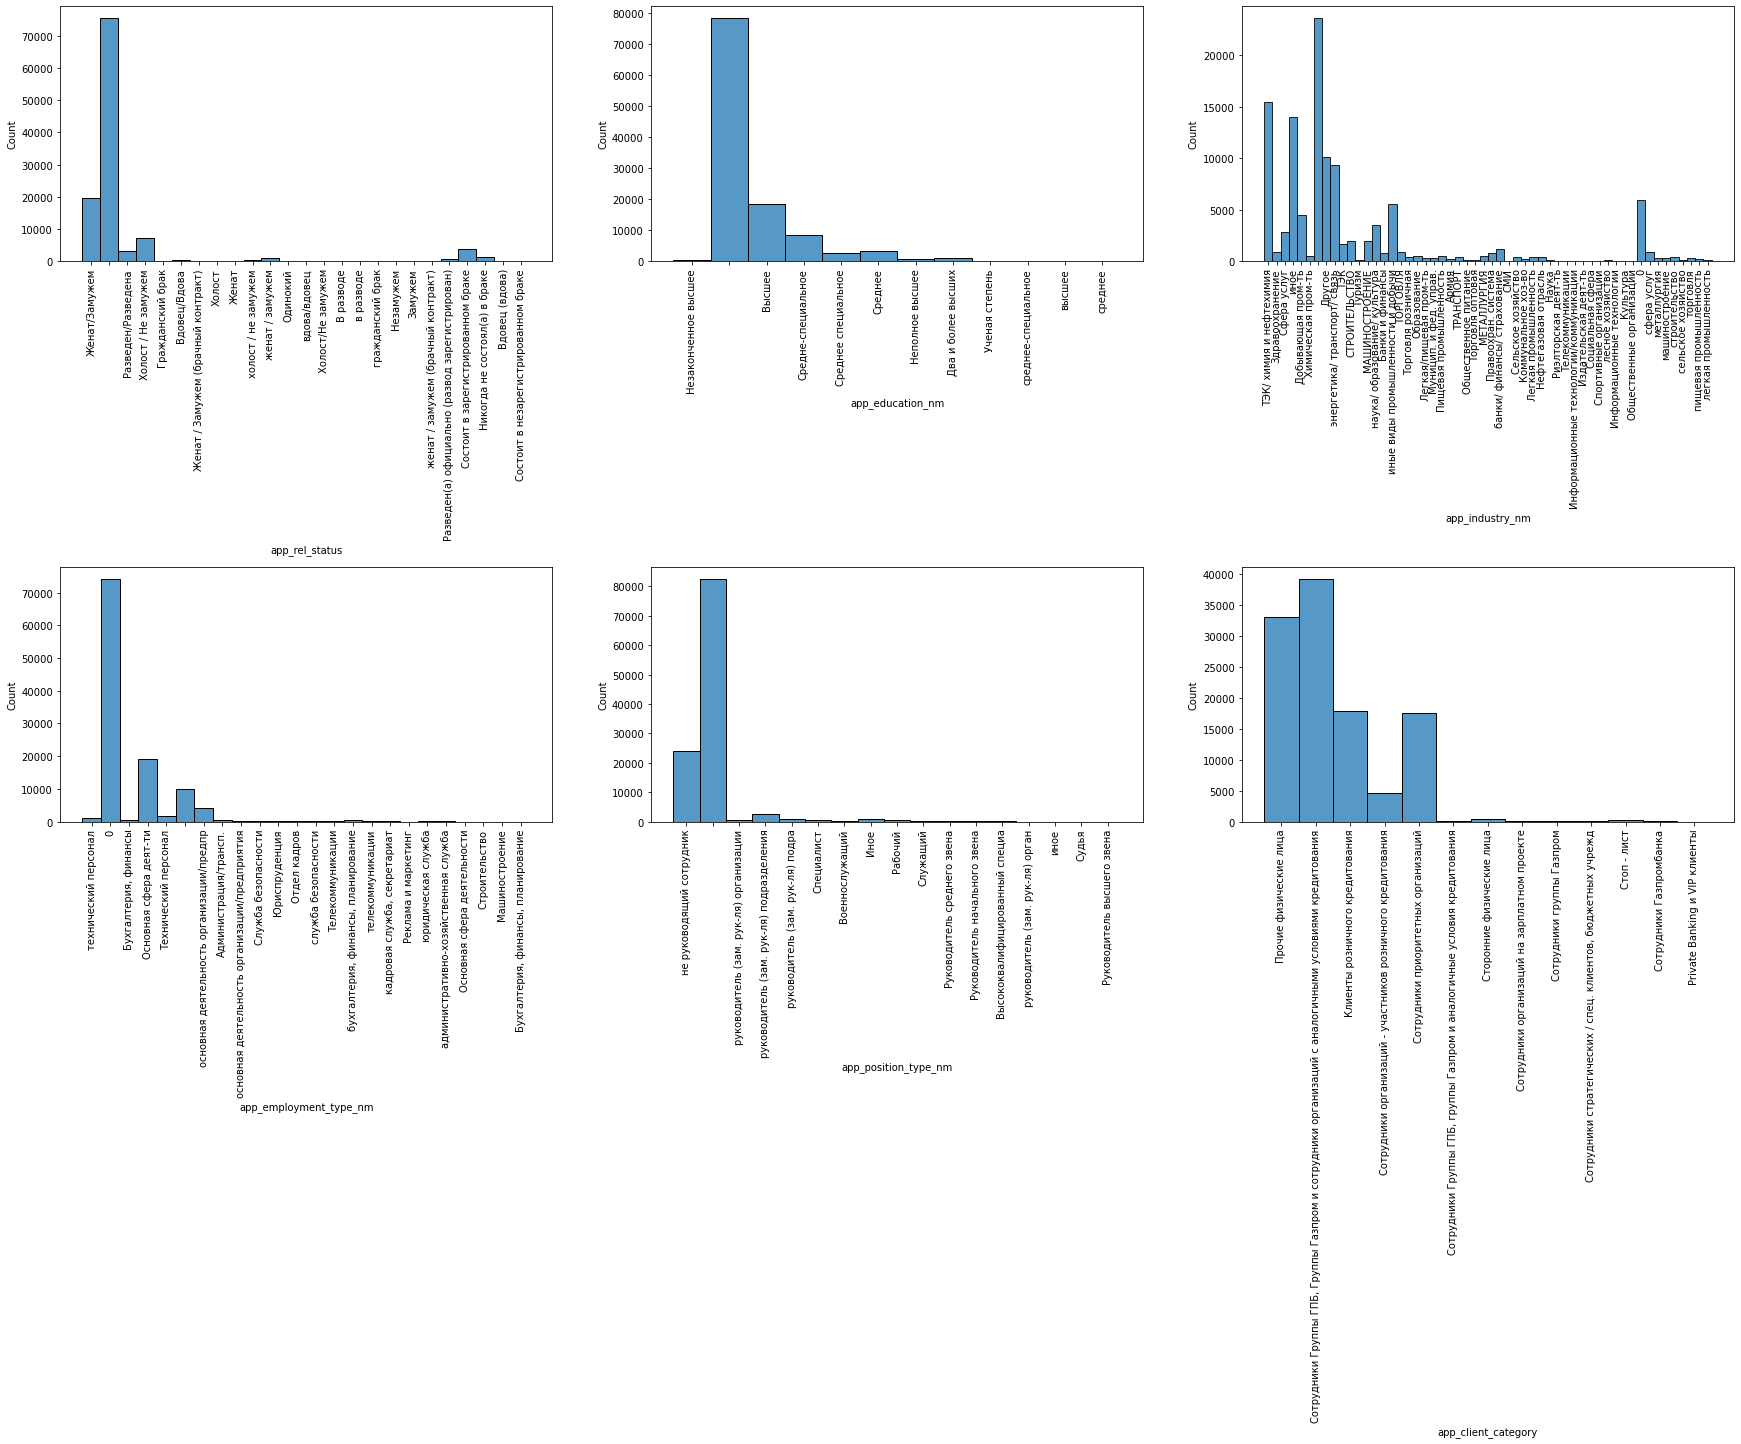

In [19]:
num_rows, num_cols = 2,3
f, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 15))
plt.subplots_adjust(hspace=1.2)

for index, column in enumerate(cat_data.columns):
    notnull_ind = cat_data[column].notnull()
    DataFrame = cat_data[notnull_ind]
    #sns.catplot(x=column, kind="count", palette="coolwarm", data=DataFrame, ax=axes[index // num_cols, index % num_cols])
    sns.histplot(x=column, data=DataFrame, ax=axes[index // num_cols, index % num_cols], palette="coolwarm")
    for tick in axes[index // num_cols, index % num_cols].get_xticklabels():
        tick.set_rotation(90)

plt.show()

Определенно точно можно сказать, что клиенты с наиболее заполнеными признаками связаны с нефтегазовой промышленностью.  
Газпромбанк — генеральный партнер соревнования, это дает судить, что скорее всего наиболее заполненные профили - партнеры / работники Газпромбанка, либо же сотрудники приоритетных организаций - партнеров.  
  
Для начала почистим категориальные признаки от дубликатов / похожих значений



### 2.1.1 Принудительное изменение регистра  
В некоторых столбцах представлены одни и те же значения, просто с разными регистрами. Например:

In [20]:
cat_data['app_education_nm'].value_counts(dropna=False)

                        78194
NaN                     64287
Высшее                  18484
Средне-специальное       8390
Среднее                  3300
Среднее специальное      2470
Два и более высших       1136
Неполное высшее           743
Незаконченное высшее      297
Ученая степень            122
высшее                     23
среднее-специальное        18
среднее                     5
Name: app_education_nm, dtype: int64

In [21]:
for column in cat_data.columns:
    cat_data[column] = cat_data[column].str.lower()

In [22]:
cat_data['app_education_nm'].value_counts(dropna=False)

                        78194
NaN                     64287
высшее                  18507
средне-специальное       8390
среднее                  3305
среднее специальное      2470
два и более высших       1136
неполное высшее           743
незаконченное высшее      297
ученая степень            122
среднее-специальное        18
Name: app_education_nm, dtype: int64

### 2.1.2 Некоторые ручные отображения  
Произведем некоторые ручные отображения по похожим признакам, которые не имеет смысла разбивать на несколько групп  

### 1) app_rel_status

In [23]:
cat_data['app_rel_status'] = cat_data['app_rel_status'].fillna('_MISSING_')

mapping = {'женат / замужем' : 'женат/замужем', 'состоит в зарегистрированном браке' : 'женат/замужем', 'гражданский брак' : 'женат/замужем', 'женат / замужем (брачный контракт)' : 'женат/замужем',
           'женат' : 'женат/замужем', 'состоит в незарегистрированном браке' : 'женат/замужем', 'замужем' : 'женат/замужем', 'женат/замужем' : 'женат/замужем',

           'никогда не состоял(а) в браке' : 'холост / не замужем', 'холост/не замужем' : 'холост / не замужем', 'одинокий' : 'холост / не замужем', 'незамужем' : 'холост / не замужем', 'холост / не замужем' : 'холост / не замужем',
           'холост' : 'холост / не замужем',
          
           'разведен(а) официально (развод зарегистрирован)' : 'разведен/разведена', 'вдовец/вдова' : 'разведен/разведена', 'в разводе' : 'разведен/разведена', 'вдовец (вдова)' : 'разведен/разведена',
           'вдова/вдовец' : 'разведен/разведена', 'разведен/разведена' : 'разведен/разведена',
           '_MISSING_' : '_MISSING_',
           ' ' : '_MISSING_'}

cat_data['app_rel_status'] = [mapping[value] for value in np.array(cat_data['app_rel_status'].values)]
cat_data['app_rel_status'].value_counts(dropna=False)

_MISSING_              139732
женат/замужем           24270
холост / не замужем      9052
разведен/разведена       4415
Name: app_rel_status, dtype: int64

### 2) app_education_nm

In [24]:
cat_data['app_education_nm'] = cat_data['app_education_nm'].fillna('_MISSING_')

mapping = {' ' : '_MISSING_', 'высшее' : 'высшее', 'средне-специальное' : 'средне-специальное', 'среднее' : 'среднее', 'среднее' : 'среднее',
           'среднее специальное' : 'средне-специальное',
           'два и более высших' : 'два и более высших',
           'неполное высшее' : 'неполное высшее', 'незаконченное высшее' : 'неполное высшее',
           'ученая степень' : 'ученая степень',
           'среднее-специальное' : 'средне-специальное',
           '_MISSING_' : '_MISSING_'}

cat_data['app_education_nm'] = [mapping[value] for value in np.array(cat_data['app_education_nm'].values)]
cat_data['app_education_nm'].value_counts(dropna=False)

_MISSING_             142481
высшее                 18507
средне-специальное     10878
среднее                 3305
два и более высших      1136
неполное высшее         1040
ученая степень           122
Name: app_education_nm, dtype: int64

### 3) app_industry_nm

In [25]:
cat_data['app_industry_nm'] = cat_data['app_industry_nm'].fillna('другое')

cat_data['app_industry_nm'] = cat_data['app_industry_nm'].apply(lambda x: 'другое' if x in [' ', 'иное'] else x)

cat_data['app_industry_nm'] = cat_data['app_industry_nm'].apply(lambda x: 'тэк/ химия и нефтехимия' if x in ['тэк', 'химическая пром-ть', 'нефтегазовая отрасль', '0'] else x)

cat_data['app_industry_nm'] = cat_data['app_industry_nm'].apply(lambda x: 'иные виды промышленности и добычи' if x in ['добывающая пром-ть', 'машиностроение', 'металлургия', 'пищевая промышленность', 'легкая/пищевая пром-ть', 
                                                                                                                       'сельское хозяйство', 'легкая промышленность'] else x)

cat_data['app_industry_nm'] = cat_data['app_industry_nm'].apply(lambda x: 'торговля' if x in ['сфера услуг', 'строительство', 'торговля розничная', 'торговля оптовая', 'риэлторская деят-ть', 'общественное питание'] else x)

cat_data['app_industry_nm'] = cat_data['app_industry_nm'].apply(lambda x: 'наука/ образование/ культура' if x in ['образованиег', 'наука', 'спортивные организации', 'культура', 'социальная сфера', 'издательская деят-ть', 'общественные организации', 
                                                                                                                  'образование', 'здравоохранение'] else x)

cat_data['app_industry_nm'] = cat_data['app_industry_nm'].apply(lambda x: 'банки/ финансы/ страхование' if x in ['банки и финансы', 'коммунальное хоз-во', 'информационные технологии', 
                                                                                                                 'информационные технологии/коммуникации', 'сми'] else x)

cat_data['app_industry_nm'] = cat_data['app_industry_nm'].apply(lambda x: 'другое' if x not in ['тэк/ химия и нефтехимия', 'иные виды промышленности и добычи', 'энергетика/ транспорт/ связь', 'торговля', 
                                                                                                'наука/ образование/ культура', 'банки/ финансы/ страхование'] else x)

### 4) app_employment_type_nm  
Не информативный признак (все основные значения, помимо NULL не содержат конкретной информации)

In [26]:
cat_data.drop(['app_employment_type_nm'], axis=1, inplace = True)

### 5) app_position_type_nm 	

In [27]:
cat_data['app_position_type_nm'] = cat_data['app_position_type_nm'].fillna('_MISSING_')

cat_data['app_position_type_nm'] = cat_data['app_position_type_nm'].apply(lambda x: '_MISSING_' if x in [' ', 'иное'] else x)
cat_data['app_position_type_nm'] = cat_data['app_position_type_nm'].apply(lambda x: 'руководитель (зам. рук-ля) подразделения' if x in ['руководитель (зам. рук-ля) подра', 'руководитель (зам. рук-ля) организации', 'руководитель среднего звена', 
                                                                                                                              'руководитель (зам. рук-ля) орган', 'руководитель высшего звена'] else x)
cat_data['app_position_type_nm'] = cat_data['app_position_type_nm'].apply(lambda x: 'не руководящий сотрудник' if x in ['специалист', 'рабочий', 'руководитель начального звена', 'высококвалифицированный специа'] else x)

cat_data['app_position_type_nm'] = cat_data['app_position_type_nm'].apply(lambda x: '_MISSING_' if x not in ['не руководящий сотрудник', 'руководитель (зам. рук-ля) подразделения'] else x)

### 6) app_client_category

In [28]:
cat_data['app_client_category'] = cat_data['app_client_category'].fillna('прочие физические лица')


cat_data['app_client_category'] = cat_data['app_client_category'].apply(lambda x: 'прочие физические лица' if x in ['сторонние физические лица', 'стоп - лист'] else x)
cat_data['app_client_category'] = cat_data['app_client_category'].apply(lambda x: 'сотрудники группы гпб, группы газпром и сотрудники организаций с аналогичными условиями кредитования' if x not in ['прочие физические лица'] else x)

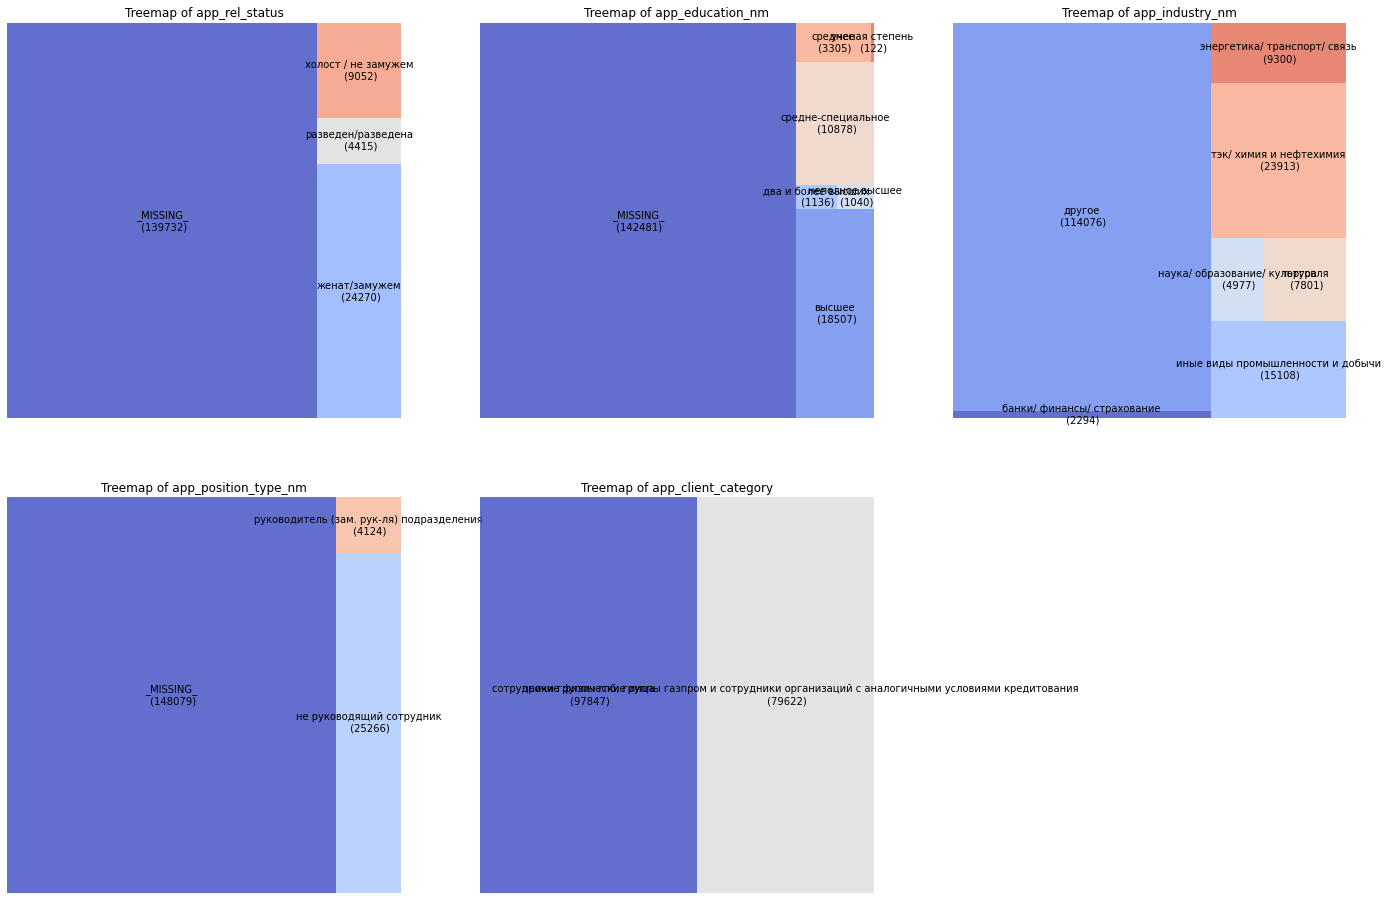

In [29]:
def treemap(DataFrame = cat_data):
    f, axes = plt.subplots(nrows = 2, ncols= 3, figsize = (24,16))
    i = 0
    for column in cat_data.columns:
        
        df = DataFrame.groupby(column).size().reset_index(name = 'counts')
        labels = df.apply( lambda x: str(x[0]) + '\n (' + str(x[1]) + ')', axis = 1)
        size = df['counts'].values
        
        colors = [plt.cm.coolwarm(i/float(len(labels))) for i in range(len(labels))]
        squarify.plot(sizes=size, label=labels, color = colors, alpha = 0.8, ax = axes[i//3, i%3])
        
        # Decorate
        axes[i//3, i%3].set_title('Treemap of {}'.format(column))
        axes[i//3, i%3].axis('off')
        i+=1
    f.delaxes(axes[1, 2])
    
treemap()

### 2.1.2 one hot encoding

In [30]:
encoder = DV(sparse = False)
cat_data_oh = encoder.fit_transform(cat_data.T.to_dict().values())

<a id='1'></a>
## <p style="background-color:LightCoral; font-family:newtimeroman; font-size:150%; text-align:center">2.2 Вещественные признаки 🔢</p>  

### 2.2.1 Отсеивание сильно коррелирующих признаков

In [31]:
"""Функция, отсекающая сильно коррелированные значения"""
def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out

cont_data1 = trimm_correlated(cont_data, 0.9)

In [ ]:
f, axes = plt.subplots(nrows = 1, ncols= 2, figsize = (25,10))

#plt.figure(figsize=(10,10))
mask = np.triu(cont_data.corr())
sns.heatmap(cont_data.corr(), annot=False, mask = mask, cmap='coolwarm',
            cbar_kws={"shrink": .8}, vmin=0, vmax=1, xticklabels = False, yticklabels = False, ax = axes[0], cbar = False)

mask = np.triu(cont_data1.corr())
sns.heatmap(cont_data1.corr(), annot=False, mask = mask, cmap='coolwarm',
            cbar_kws={"shrink": .8}, vmin=0, vmax=1, xticklabels = False, yticklabels = False, ax = axes[1])

axes[0].set_title('До удаления коррелирующих признаков', size = 14)
axes[1].set_title('После удаления коррелирующих признаков', size = 14)

In [32]:
delta = cont_data.shape[1] - cont_data1.shape[1]
print(Fore.GREEN + 'Колличество признаков уменьшилось на {}'.format(delta))

Колличество признаков уменьшилось на 87


### 2.2.3 Поиск выбросов

Text(0.5, 1.0, 'Максимальный ежемесячный платеж')

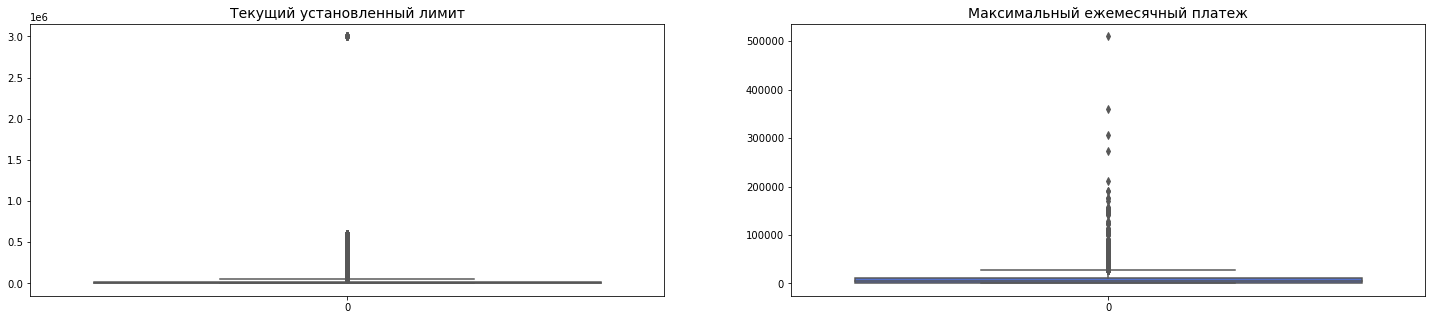

In [33]:
f, axes = plt.subplots(nrows = 1, ncols= 2, figsize = (25,5))

sns.boxplot(data = cont_data1['cur_credit_limit'], color = 'royalblue', ax = axes[0])
sns.boxplot(data = cont_data1['max_paym_bank'], color = 'royalblue', ax = axes[1])


axes[0].set_title('Текущий установленный лимит', size = 14)
axes[1].set_title('Максимальный ежемесячный платеж', size = 14)

In [34]:
"""На время удаляем столбец с id"""
filt_cont_data1 = cont_data1.iloc[:, 4 : cont_data1.shape[1]]

"""Вычисляем процентили"""
low = .05
high = .95
quant_df = filt_cont_data1.quantile([low, high])

"""Отсеиваем выбросы на основе процентилей"""
filt_cont_data1 = filt_cont_data1.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
                                                    (x < quant_df.loc[high,x.name])], axis=0)

"""Возвращаем столбец с id"""
cont_data2 = pd.concat([cont_data1.loc[:,['client_id', 'weekday', 'month', 'year']], filt_cont_data1], axis=1)

Text(0.5, 1.0, 'Максимальный ежемесячный платеж')

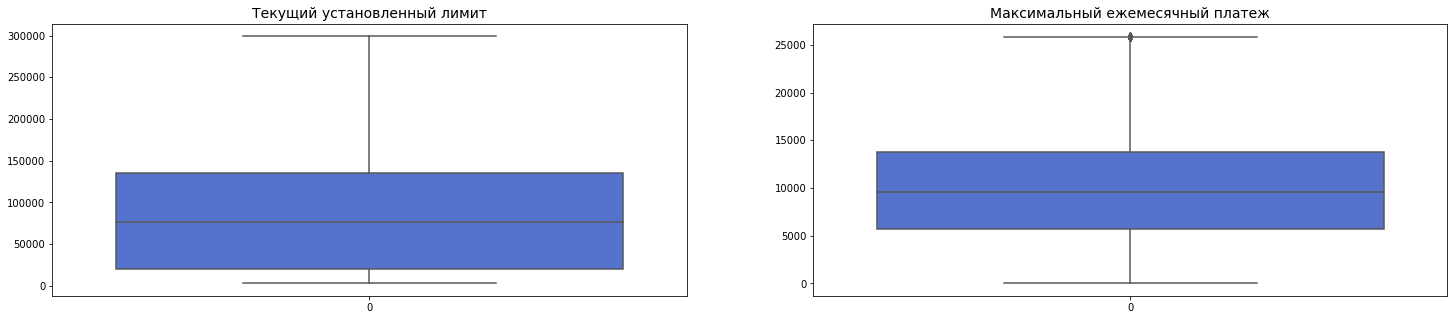

In [35]:
f, axes = plt.subplots(nrows = 1, ncols= 2, figsize = (25,5))

sns.boxplot(data = cont_data2['cur_credit_limit'], color = 'royalblue', ax = axes[0])
sns.boxplot(data = cont_data2['max_paym_bank'], color = 'royalblue', ax = axes[1])

axes[0].set_title('Текущий установленный лимит', size = 14)
axes[1].set_title('Максимальный ежемесячный платеж', size = 14)

In [36]:
bool_cols = []
for column in cont_data1.columns:
    if cont_data1[column].isin([0.,1., np.NaN]).all():
        bool_cols.append(column)
        
cont_data1[bool_cols] = cont_data1[bool_cols].astype('Bool')

In [38]:
cont_data_informative = cont_data2.copy()
cont_data_informative

,client_id,weekday,month,year,cnt_zp_1m,cnt_zp_3m,downlimit_count,uplimit_count,cur_credit_limit,cur_cr_lim_month,...,NON FOOD RETAIL_attsummin,NON FOOD RETAIL_attsummax,LEGAL SERVICES_attsum,LEGAL SERVICES_attcnt,CHARITY_attsum,CHARITY_attcnt,CHARITY_attsummin,UNKNOWN_attsum,UNKNOWN_attcnt,UNKNOWN_attsummin
0,100,1,1,2019,2.0,6.0,2.0,4.0,20000.0,10.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,733,1,1,2019,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8584,1,1,2019,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,767,1,1,2019,2.0,6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5900,1,1,2019,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177464,7058,3,10,2020,2.0,4.0,NaN,1.0,9999.0,5.94,...,39.8,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177465,2427,3,10,2020,2.0,4.0,NaN,NaN,NaN,NaN,...,163.0,5950.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177466,2137,3,10,2020,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177467,9641,3,10,2020,3.0,8.0,NaN,1.0,NaN,9.29,...,86.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.2.2 Нормализация значений  
В данном случае, при наличии большого количества NaN значений не рекоммендуется использовать пакет из sklearn.  
Поэтому реализуем функцию нормализации сами.  
**Используем тактику масштабирования признаков на отрезок [0,1]**

In [39]:
for column in cont_data2.columns:
    cont_data2[column]=(cont_data2[column]-cont_data2[column].min())/(cont_data2[column].max()-cont_data2[column].min())

### 2.2.3 Заполнение NaN значений

In [40]:
cont_data2.fillna(0, inplace = True)
cont_data_informative.fillna(0, inplace = True)

In [41]:
cont_data_informative

,client_id,weekday,month,year,cnt_zp_1m,cnt_zp_3m,downlimit_count,uplimit_count,cur_credit_limit,cur_cr_lim_month,...,NON FOOD RETAIL_attsummin,NON FOOD RETAIL_attsummax,LEGAL SERVICES_attsum,LEGAL SERVICES_attcnt,CHARITY_attsum,CHARITY_attcnt,CHARITY_attsummin,UNKNOWN_attsum,UNKNOWN_attcnt,UNKNOWN_attsummin
0,100,1,1,2019,2.0,6.0,2.0,4.0,20000.0,10.42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,733,1,1,2019,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8584,1,1,2019,3.0,4.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,767,1,1,2019,2.0,6.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5900,1,1,2019,0.0,8.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177464,7058,3,10,2020,2.0,4.0,0.0,1.0,9999.0,5.94,...,39.8,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177465,2427,3,10,2020,2.0,4.0,0.0,0.0,0.0,0.00,...,163.0,5950.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177466,2137,3,10,2020,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177467,9641,3,10,2020,3.0,8.0,0.0,1.0,0.0,9.29,...,86.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id='1'></a>
## <p style="background-color:LightCoral; font-family:newtimeroman; font-size:150%; text-align:center">2.3 Объединение таблиц 🧰</p>  

In [42]:
#print(list(cont_data2.columns))

['client_id', 'weekday', 'month', 'year', 'cnt_zp_1m', 'cnt_zp_3m', 'downlimit_count', 'uplimit_count', 'cur_credit_limit', 'cur_cr_lim_month', 'prev_credit_limit', 'max_outstanding_amount_1m', 'max_ovd_amount_1m', 'max_utilization_1m', 'total_num_cards', 'cnt_active', 'cnt_cur', 'first_opened', 'last_opened', 'last6m_opened', 'last6m1y_opened', 'num_credit_cards', 'num_prem_cards', 'extra_card_ind', 'actual_credit_card_flg', 'cnt_dep_5y', 'cnt_dep_act', 'cnt_dep_6m', 'cnt_prolong_max', 'amt_min_prlg_max', 'cnt_prolong_max_5y', 'amt_min_prlg_max_5y', 'cnt_foreign_cur_5y', 'max_term_50_5y_closed', 'max_term_50_5y_open', 'max_term_closed', 'max_term_open', 'cnt_term_g1y_closed', 'cnt_term_g1y_open', 'min_amt_term_g1y_closed', 'min_amt_term_g1y_open', 'cnt_early_withdraw_5y', 'cnt_account_5y', 'max_amt_dep_5y', 'max_amt_dep_act', 'max_amt_foreign_cur_5y', 'sum_dep_now', 'sum_acc_now', 'avg_sum_cls2op', 'avg_sum_nws2op', 'max_max_dep_balance', 'min_max_dep_balance', 'max_max_dep_income', '

In [43]:
X = np.hstack((cont_data2, cat_data_oh))

<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">3. Тренировка модели 🏃🏻</p>  
В данном случае решаем задачу кластеризации. Рассмотрим несколько моделей

In [56]:
"""В процессе визуализации будем смотреть на интересующие нас признаки"""
features = ['cur_credit_limit', 'max_outstanding_amount_1m', 'max_utilization_1m', 'total_num_cards', 'cnt_dep_5y', 'cnt_prolong_max', 'max_paym_bank', 'bank_liab_paym']

features_label = ['текущий установленный лимит', 'максимум просроченной задолженности за месяц', 'максимальные траты по карте за последний месяц', 
                  'общее количество счетов ', 'количество срочных депозитов (т.е. имеющих срок, не "до востребования"), открытых за последние 5 лет',
                  'максимальное количество пролонгаций по всем срочным депозитам', 'максимальный ежемесячный платеж', 'общая сумма платежей по действующим на данный момент кредитам']

feat_df = cont_data_informative[features]

<a id='1'></a>
## <p style="background-color:LightCoral; font-family:newtimeroman; font-size:150%; text-align:center">3.1 K-means 🌳</p>  

In [46]:
#K means Clustering 
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(feat_df, 2)
kmeans = pd.DataFrame(clust_labels)
feat_df.insert((feat_df.shape[1]),'kmeans',kmeans)

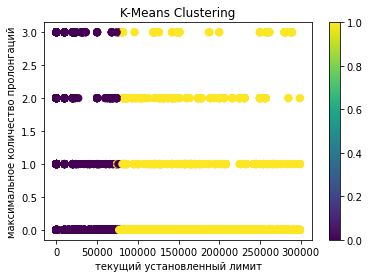

In [59]:
#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(feat_df['cur_credit_limit'],feat_df['cnt_prolong_max'],
                     c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('текущий установленный лимит')
ax.set_ylabel('максимальное количество пролонгаций')
plt.colorbar(scatter)

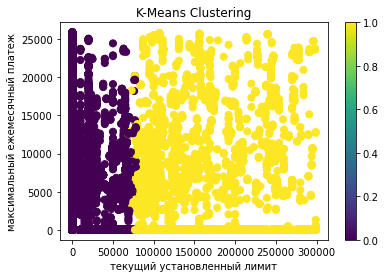

In [60]:
#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(feat_df['cur_credit_limit'],feat_df['max_paym_bank'],
                     c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('текущий установленный лимит')
ax.set_ylabel('максимальный ежемесячный платеж')
plt.colorbar(scatter)

<a id='1'></a>
## <p style="background-color:LightCoral; font-family:newtimeroman; font-size:150%; text-align:center">3.1 DBSCAN </p>  

Вывод: эх денечек бы еще